In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_swiss_roll
import DiffusionModel as DM
import torch.optim as optim
import seaborn as sns
import torch.nn as nn
from celluloid import Camera
import torch.optim as optim

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Se define la distribución de probabilidad $q(x_0)$ que se quiere aprender


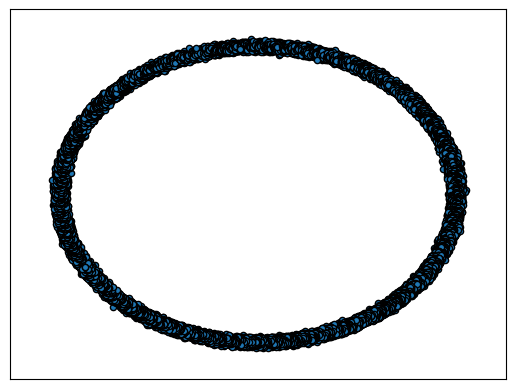

In [5]:
#DISTRIBUCIÓN DE PROBABILIDAD EN CUESTIÓN QUE SE QUIERE APRENDER

n_samples=100000
rho=1.2
x = rho * np.array([
    [np.sin(i/15000 * 2 * np.pi) + np.random.randn() * rho * 0.01,
     np.cos(i/15000 * 2 * np.pi) + np.random.randn() * rho * 0.01] for i in range(n_samples)
     ])

#data = (data - data.mean(axis=0)) / data.std(axis=0)
plt.scatter(x[:,0], x[:,1], c='#1f77b4', marker='o', s=20,  edgecolor='black')
#plt.title(r"$q(x_0)$")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xticks([])
plt.yticks([])
plt.show()

X = torch.tensor(x, dtype=torch.float32)

## Definición de los parámetros de la cadena de Markov de difusión

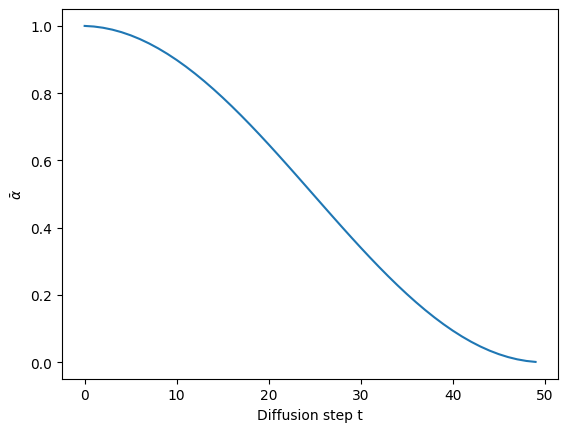

In [6]:
diffusion_steps = 50

# Parámetros definidos de acuerdo al paper de Nichol & Dariwal (https://arxiv.org/pdf/2102.09672.pdf)
# Con el objetivo de optimizar el proceso de aprendizaje.
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

sns.lineplot(baralphas)
plt.xlabel("Diffusion step t")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

## Modelado del Forward Diffusion Process para la distribución de probabilidad objetivo $q(x_t|x_{t-1})$:
### $x_t|x_{0} = \sqrt{(\bar{\alpha_t})} x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon$

### De acuerdo a la ecuación (4) del paper de Ho. et al.

In [7]:
def diffuse(Xbatch, t):
    epsilon = torch.randn(size=Xbatch.shape)
    #.repeat to transform baralphas to adequate dimension: a vector of same size as Xbatch:
    diffused = np.sqrt(baralphas[t]).repeat(1,Xbatch.shape[1]) * Xbatch + (np.sqrt(1-baralphas[t])).repeat(1,Xbatch.shape[1]) * epsilon
    return diffused, epsilon

In [ ]:
camera = Camera(plt.figure())
for t in range(20):
    diffused, _ = diffuse(X, torch.full([len(X), 1], fill_value=t))
    plt.title(str("Forward Diffusion Process"))
    plt.scatter(diffused[:, 0], diffused[:, 1], c='#1f77b4', marker='o', s=20,  edgecolor='black')
    camera.snap()

anim = camera.animate(blit=True)
anim.save('scatter.gif')

In [ ]:
from IPython.display import HTML

HTML("""
<div align="middle">
  <IMG SRC="scatter.gif">
</div>""")


## Instanciación del modelo


In [9]:
model = DM.DiffusionModel(nInputs=2, nLayers=4)

device = "cuda"
model = model.to(device)

model

DiffusionModel(
  (inputBlock): Linear(in_features=3, out_features=64, bias=True)
  (diffLayers): ModuleList(
    (0-3): 4 x DiffusionLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outputBlock): Linear(in_features=64, out_features=2, bias=True)
)

In [10]:


nepochs = 100
batch_size = 2048

# Loss Function is MSE
loss_fn = nn.MSELoss()
# Adam Optimizer, this is the gradient descent method
optimizer = optim.Adam(model.parameters(), lr=0.001)
# LR Schedule
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

for epoch in range(nepochs):
    epoch_loss = steps = 0  # Initialize epoch's loss

    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size] # Takes a Portion of particles from the complete X particles set
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1]) # Samples random t
        noised, eps = diffuse(Xbatch, timesteps) # Returns a noised Xbatch and the corresponding noises (epsilons)
        predicted_noise = model(noised.to(device), timesteps.to(device)) # Makes the model predict noise, given the current weights
        loss = loss_fn(predicted_noise, eps.to(device)) # Loss of the computation. Compares predicted eps to real eps
        optimizer.zero_grad() # Sets to zero all grads before backpropagating
        loss.backward() # Backpropagates the gradient of the loss function
        optimizer.step() # Performs a single optimization step (parameter update).
        epoch_loss += loss
        steps += 1
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 0.7696325778961182
Epoch 1 loss = 0.7287440896034241
Epoch 2 loss = 0.6183093786239624
Epoch 3 loss = 0.5808639526367188
Epoch 4 loss = 0.5681858658790588
Epoch 5 loss = 0.5456051826477051
Epoch 6 loss = 0.5428868532180786
Epoch 7 loss = 0.5316635966300964
Epoch 8 loss = 0.5618022084236145
Epoch 9 loss = 0.511772096157074
Epoch 10 loss = 0.5309727787971497
Epoch 11 loss = 0.5047442317008972
Epoch 12 loss = 0.5103392601013184
Epoch 13 loss = 0.47185608744621277
Epoch 14 loss = 0.48259106278419495
Epoch 15 loss = 0.4720211327075958
Epoch 16 loss = 0.4392728805541992
Epoch 17 loss = 0.4560813009738922
Epoch 18 loss = 0.442759245634079
Epoch 19 loss = 0.45823928713798523
Epoch 20 loss = 0.43770602345466614
Epoch 21 loss = 0.4404296278953552
Epoch 22 loss = 0.41510507464408875
Epoch 23 loss = 0.4355435073375702
Epoch 24 loss = 0.40408799052238464
Epoch 25 loss = 0.4289902448654175
Epoch 26 loss = 0.3976643979549408
Epoch 27 loss = 0.4201400578022003
Epoch 28 loss = 0.40097364

In [11]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad(): # Context-manager that disables gradient calculation.
        x = torch.randn(size=(nsamples, nfeatures)).to(device) # Generation of random noise distribution Data positions. nfeatures = Problem Dimensionality
        xt = [x] # x to list?
        # Sampling Loop
        for t in range(diffusion_steps-1, 0, -1): # Reverse Diffusion time Schedule
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device)) # Predicts noise for all x, given currently at time t
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise) # DETERMINISTIC Reverse Diffusion Step
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device) # NOW, add RANDOM noise
            xt += [x]

        return x, xt

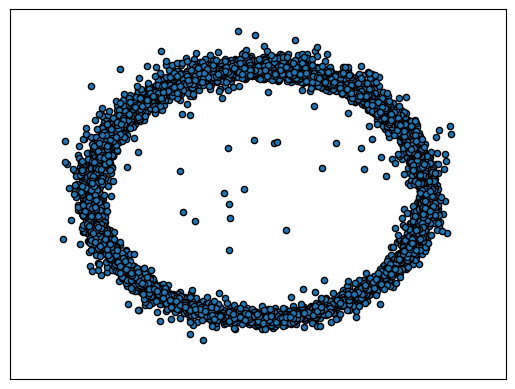

In [13]:
Xgen, Xgen_hist = sample_ddpm(model, 10000, 2)
Xgen = Xgen.cpu()
#plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], c='#1f77b4', marker='o', s=20,  edgecolor='black')
#plt.legend(["Original data", "Generated data"])
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
plt.xticks([])
plt.yticks([])
plt.show()

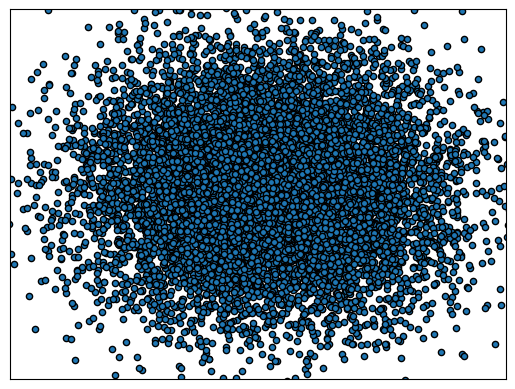

In [15]:
points = Xgen_hist[1].cpu()

#plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(points[:, 0], points[:, 1], c='#1f77b4', marker='o', s=20,  edgecolor='black')
#plt.legend(["Original data", "Generated data"])
plt.xlim(-2.8, 2.8)
plt.ylim(-2.8, 2.8)
plt.xticks([])
plt.yticks([])
plt.show()

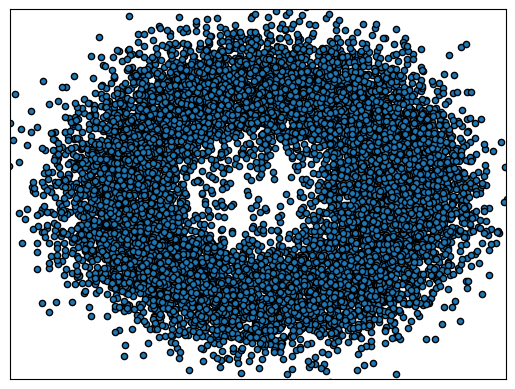

In [21]:
points = Xgen_hist[40].cpu()

#plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(points[:, 0], points[:, 1], c='#1f77b4', marker='o', s=20,  edgecolor='black')
#plt.legend(["Original data", "Generated data"])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xticks([])
plt.yticks([])
plt.show()

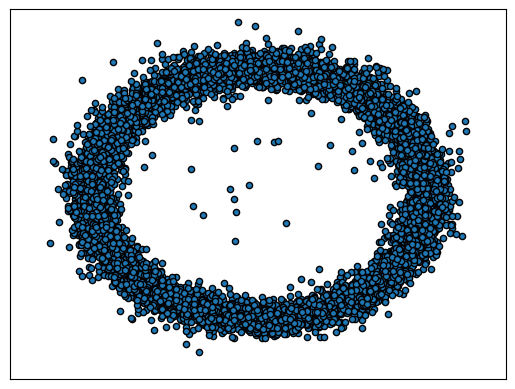

In [19]:
points = Xgen_hist[48].cpu()

#plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(points[:, 0], points[:, 1], c='#1f77b4', marker='o', s=20,  edgecolor='black')
#plt.legend(["Original data", "Generated data"])
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
plt.xticks([])
plt.yticks([])
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


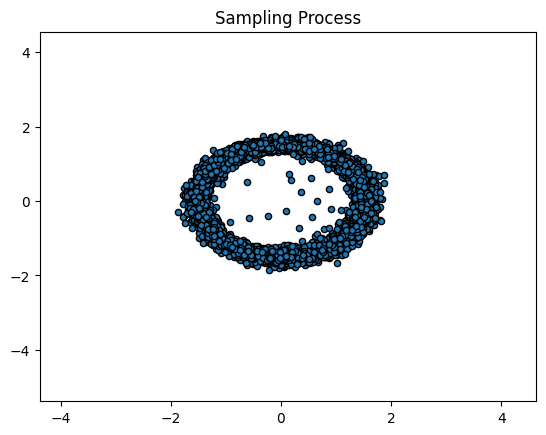

In [ ]:


camera = Camera(plt.figure())
for t in np.arange(0,diffusion_steps,4):
    points = Xgen_hist[t].cpu()
    plt.title(str("Sampling Process"))
    plt.scatter(points[:, 0], points[:, 1], c='#1f77b4', marker='o', s=20,  edgecolor='black')
    camera.snap()

anim = camera.animate(blit=True)
anim.save('samplingF.gif')

In [ ]:
from IPython.display import HTML

HTML("""
<div align="middle">
  <IMG SRC="samplingF.gif">
</div>""")